In [1]:
import sys
sys.path.append('../Codes/')
sys.path.append('../Codes/Python/')
import numpy as np
import matplotlib.pyplot as plt
from Immuno_models import*
#from Bio import Phylo
from io import StringIO
from matplotlib.lines import Line2D
from datetime import datetime, timedelta
import scipy.special as sc
import os.path
import pickle
from matplotlib import style
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from IPython.display import display, Math

def my_linear_func(x, a, b):
    return a + b*x
def my_quadratic_func(x, a, b, c):
    return a - b*(x-c)**2

Text_files_path = '../../../../Dropbox/Research/Evolution_Immune_System/Text_files/'

N_A = 6.02214076e23
k_BT = 1.380649e-23*293
style.use('seaborn-paper')
print(style.available)
%autosave 60

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


Autosaving every 60 seconds


# The Energy Matrix

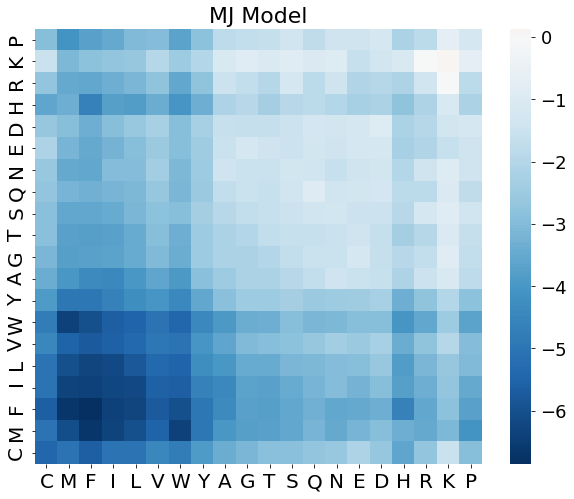

In [2]:
M2 = np.loadtxt(Text_files_path + 'MJ2.txt', skiprows= 1, usecols=range(1,21))
M2_list = M2.tolist()
Alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't']
Alphabet = np.loadtxt(Text_files_path + 'Alphabet.txt', dtype=bytes, delimiter='\t').astype(str)
Alphabet_list = Alphabet.tolist()
L_alphabet = len(Alphabet)
fig, ax = plt.subplots(figsize=(10,8))
plot_energy_matrix(Energy_Matrix=M2_list, Alphabet=Alphabet, title=r'MJ Model', ax = ax)


## Distribution of energy contributions

12.8303985


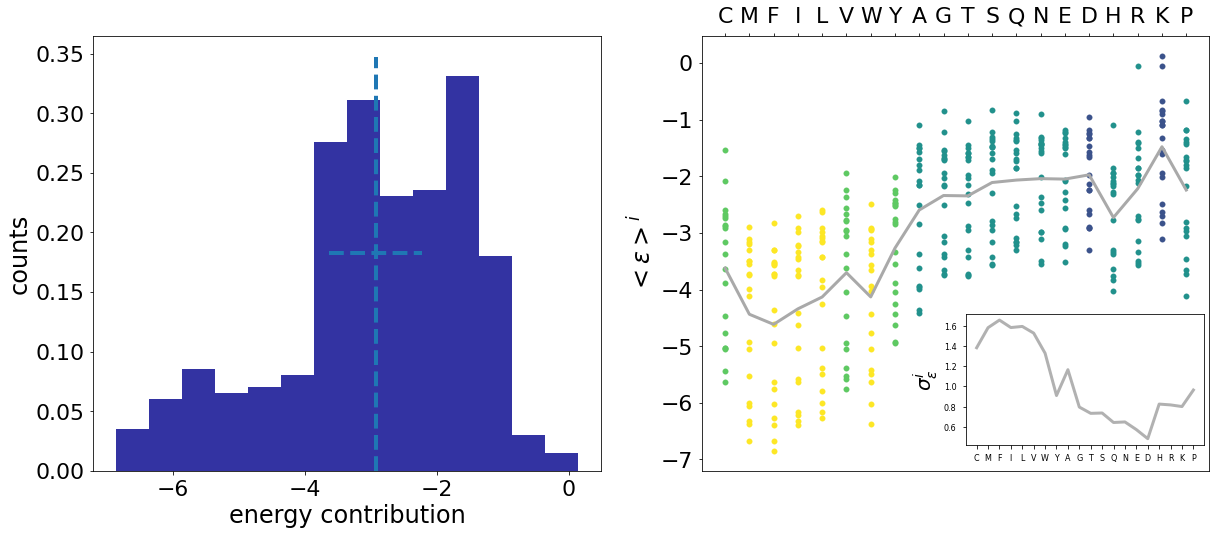

In [3]:
fig, ax = plt.subplots(1,2,figsize=(20,8))
linear_M = np.reshape(M2, (20*20,1))
mean_M = np.mean(linear_M)
var_M = np.var(linear_M)
colors = plt.cm.viridis(np.linspace(0,1,5))
ax[0].hist(linear_M, density = True, bins = 'auto', color = 'darkblue', alpha = 0.8);
ax[0].vlines(mean_M, 0, ax[0].get_ylim()[1], linestyle= 'dashed', linewidth = 4)
ax[0].hlines(ax[0].get_ylim()[1]/2, mean_M - np.sqrt(var_M)/2, mean_M + np.sqrt(var_M)/2, linestyle= 'dashed', linewidth = 4)
ax[0].set_xlabel('energy contribution', fontsize = 24)
ax[0].set_ylabel('counts', fontsize = 24)
ax[0].tick_params(labelsize = 22)
varians = np.array([])
means = np.array([])
for i, column in enumerate(M2_list):
    var_i = np.var(column)
    varians = np.append(varians, var_i)
    mean_i = np.mean(column)
    means = np.append(means, mean_i)
    ax[1].scatter(np.ones(20)*i, column, color = colors[int(abs(mean_i))])

ax[1].plot(range(L_alphabet) , means , color = 'darkgrey', alpha = 1, linewidth = 3);
#ax[1].hist(column, density = True, bins = 'auto', color = 'darkblue', alpha = 0.8);
ax[1].set_ylabel(r'$<{\epsilon}>^i$', fontsize = 24)
#ax[1].set_xlabel('aa', fontsize = 24)
ax[1].xaxis.set_label_position('top') 
ax[1].xaxis.tick_top()
ax[1].set_xticks(range(20))
ax[1].set_xticklabels(Alphabet)
ax[1].tick_params(labelsize = 22)

axin1 = ax[1].inset_axes([.52, 0.06, 0.47, 0.3])
axin1.plot(range(L_alphabet), varians , color = 'darkgrey', alpha = 0.9, linewidth = 3);
#axin1.hist(means, density = True, bins = 'auto', color = 'darkblue', alpha = 0.8);
#axin1.vlines(mean_i, 0, 1, linestyle= 'dashed', linewidth = 4)
#axin1.hlines(ax[0].get_ylim()[1]/2, mean_i - np.sqrt(var_i), mean_i + np.sqrt(var_i), linestyle= 'dashed', linewidth = 4)
axin1.set_ylabel(r'$\sigma^i_{\epsilon}$', fontsize = 20)
#axin1.set_xlabel('aa', fontsize = 24)
axin1.set_xticks(range(20))
axin1.set_xticklabels(Alphabet)
axin1.tick_params(labelsize = 8)
print((np.max(varians)*12 + np.min(varians)*12)/2)

In [4]:
print(np.log10(17**10),np.log10(20**10))

12.30448921378274 13.010299956639813


## Output from MCMC

## Different Ts

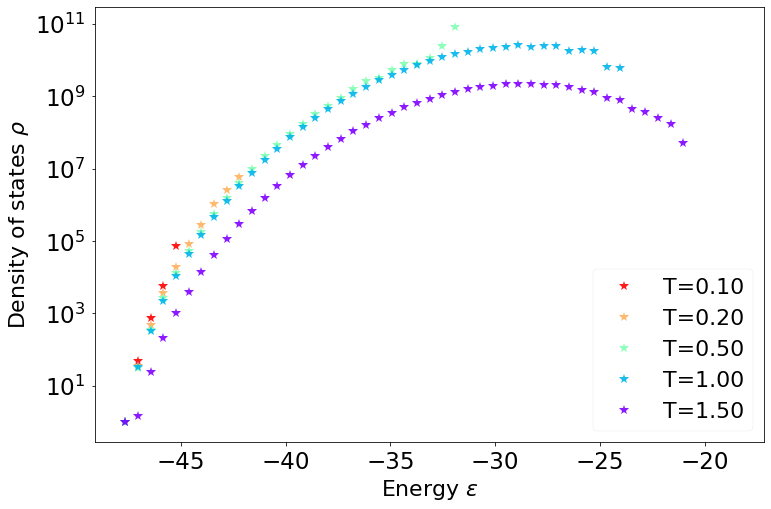

In [62]:
fig, ax = plt.subplots(1, 1, figsize = (12,8))
antigen = 'TACNSEYPNTTK'
L = 12
N = 1e8
Ts = np.array([0.1, 0.2, 0.5, 1, 1.5])
colors = np.flip(plt.cm.rainbow(np.linspace(0,1,len(Ts))), axis = 0)
markers = ['^', 'o', 's', '*', 'x']
E_0s = np.array([])
for i, T in enumerate(Ts):
    energies = (np.loadtxt(Text_files_path + 'MCMC/energies_L-%d_T-%.6f_N-%d_Antigen-'%(L, T, N)+antigen+'.txt'))
    ds = np.linspace(0, L);
    data_E = np.histogram(energies, bins =np.linspace(-47.66, -18, 50), density = False);
    #data_E = np.histogram(energies, bins ='auto', density = False);
    #E_0s = np.append(E_0s, data_E[0][0]/(np.exp(-data_E[1][0]/T)))
    ax.plot(data_E[1][:-1], (data_E[0]/(np.exp(-data_E[1][:-1]/T)))/(data_E[0][0]/(np.exp(-data_E[1][0]/T))), color = colors[i], linestyle = '', marker = '*', ms = 10, alpha = 0.9, label = "T=%.2f"%(T));
    #ax[1].plot(data_E_2[1][:-1], (data_E_2[0]/(np.exp(-data_E_2[1][:-1]/T)))/(data_E_2[0][0]/(np.exp(-data_E_2[1][0]/T))), color = colors[i], linestyle = '', marker = '*', ms = 10, alpha = 0.9, label = "T=%.2f"%(T));
    #ax[0].plot(data_E[1][:-1], data_E[0], color = 'olive', linestyle = '', marker = '*', ms = 10);
    
#ax.set_ylim(1,4e9)
ax.set_yscale('log');
ax.set_xlabel('Energy $\epsilon$', fontsize = 22)
ax.set_ylabel(r'Density of states $\rho$', fontsize = 22)
ax.tick_params(labelsize = 23)
ax.legend(loc = 4, fontsize = 22)

fig.savefig('../Figures/Density_of_States_MCMC_BCRs_MJ_T.png')

## Different Ns

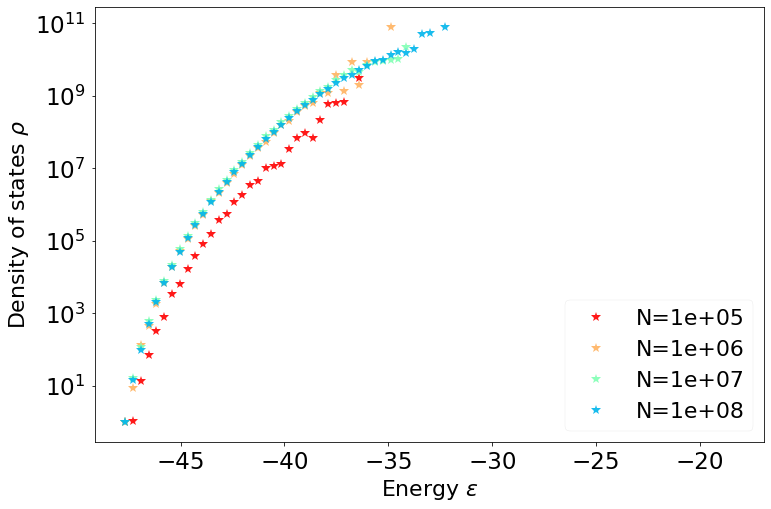

In [67]:
fig, ax = plt.subplots(1, 1, figsize = (12,8))

L = 12
Ns = np.logspace(5,8,4)
colors = np.flip(plt.cm.rainbow(np.linspace(0,1,len(Ts))), axis = 0)
markers = ['^', 'o', 's', '*', 'x']
E_0s = np.array([])
T = .5
for i, N in enumerate(Ns):
    energies = (np.loadtxt(Text_files_path + 'MCMC/energies_L-%d_T-%.6f_N-%d_Antigen-'%(L, T, N)+antigen+'.txt'))
    ds = np.linspace(0, L);
    data_E = np.histogram(energies, bins =np.linspace(-47.66, -18, 80), density = False);
    ax.plot(data_E[1][:-1], (data_E[0]/(np.exp(-data_E[1][:-1]/T)))/(data_E[0][0]/(np.exp(-data_E[1][0]/T))), color = colors[i], linestyle = '', marker = '*', ms = 10, alpha = 0.9, label = "N=%.0e"%(N));

#ax.set_ylim(1,4e9)
ax.set_yscale('log');
ax.set_xlabel('Energy $\epsilon$', fontsize = 22)
ax.set_ylabel(r'Density of states $\rho$', fontsize = 22)
ax.tick_params(labelsize = 23)
ax.legend(loc = 4, fontsize = 22)

fig.savefig('../Figures/Density_of_States_MCMC_BCRs_MJ_N.png')

In [20]:
antigens = np.array(['IMLWCMYLILWM', 'TACNSEYPNTTK', 'QRKDGPKQKKEN'])
antigen = 'TACNSEYPNTTK'
T = .5
L = 12
N_MCMC = 1e8
N_dynamics = 1e6
N_random = 1e4
data_MCMC=np.loadtxt(Text_files_path + 'MCMC/output_L-%d_T-%.6f_N-%d_Antigen-'%(L,T, N_MCMC)+antigen+'.txt')
data_dynamics_tail=np.loadtxt(Text_files_path + 'Dynamics/ensemble/energies_tail_ensemble_L-%d_N-%d_Antigen-'%(L, N_dynamics)+antigen+'.txt')
data_random=np.loadtxt(Text_files_path + 'Random/energies_random_L-%d_N-%d_Antigen-'%(L, N_random)+antigen+'.txt')


data_MCMC_rho = np.histogram(data_MCMC, bins = 60, density = False) # Creating histograms
data_dynamics_tail_rho = np.histogram(data_dynamics_tail[:,0], bins = 15, density = False) # Creating histograms
data_random_rho = np.histogram(data_random, bins = 20, density = False) # Creating histograms
e_MS = np.min(data_MCMC)
print(e_MS)

-47.66


-28.496500000000005 10.01854375


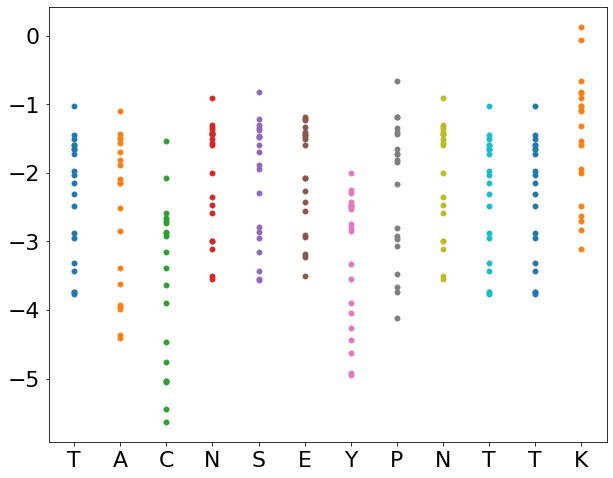

In [21]:
antigen_list = [i for i in antigen]
contributions = np.zeros(shape = (1,20))
fig, ax = plt.subplots(figsize=(10,8))
for i, aa in enumerate(antigen_list):
    index = Alphabet_list.index(aa)
    contributions = np.vstack((contributions, M2[index]))
    ax.scatter(np.ones(20)*i, M2[index])
ax.set_xticks(range(L))
ax.set_xticklabels(antigen)
ax.tick_params(labelsize = 22)
varians = np.var(contributions, axis = 1)
means = np.mean(contributions, axis = 1)
sum_mean = np.sum(means)
sum_var = np.sum(varians)
print(sum_mean, sum_var)

[106.10130324   1.93094564] [ 33.96335211   0.0533154  -28.94595171]
mean =  -28.945951711696157 -28.496500000000005
sigma2 =  9.37815380266076 10.01854375
b =  1.2853327575928517 1.248035673847309 1.9309456387372292
b1 =  1.3478505795814881 b2: 1.248035673847309
15.649588643640865 15.612359947967775


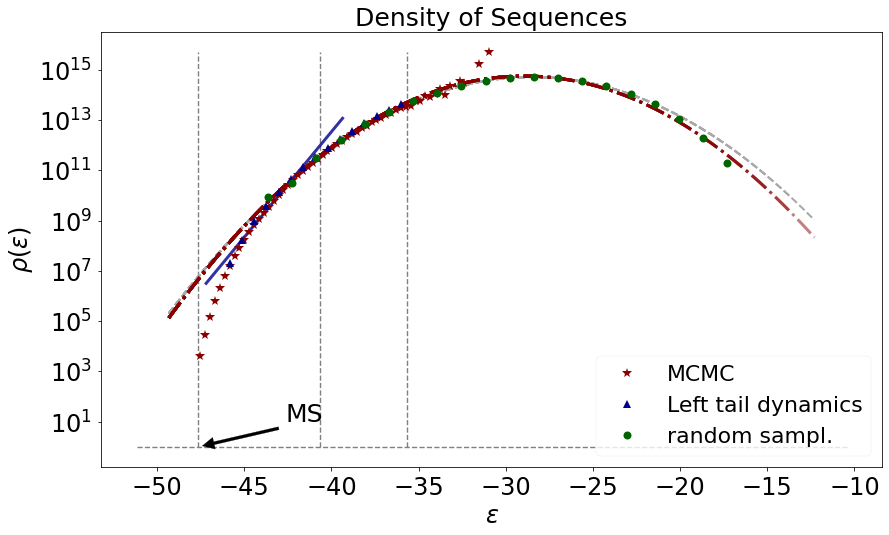

In [28]:
colors = np.flip(plt.cm.rainbow(np.linspace(0,1,3)), axis = 0)
markers = ['^', 'o', 's', '*', 'x']
E_0s = np.array([])

naive_range = 5
bcell_range = 12
fig, ax = plt.subplots(figsize = (14,8))

# --------------- MCMC -------dynamics--------
e_max_MCMC = data_MCMC_rho[1][-2]
e_min_MCMC = data_MCMC_rho[1][0]

e_MCMC = data_MCMC_rho[1][:-1] + abs(data_MCMC_rho[1][1:]-data_MCMC_rho[1][:-1])/2
rho_e_MCMC = (data_MCMC_rho[0]/(np.exp(-e_MCMC/T)))*4e42

ax.plot(e_MCMC, rho_e_MCMC, linestyle = "", marker = '*', color = 'darkred', ms = 10, alpha = 1, label = 'MCMC',zorder=20)


# --------------- Dynamics ---------------
e_max_dynamics_tail = data_dynamics_tail_rho[1][-2]
e_min_dynamics_tail = data_dynamics_tail_rho[1][0]

e_dynamics_tail = data_dynamics_tail_rho[1][:-1] + abs(data_dynamics_tail_rho[1][1:]-data_dynamics_tail_rho[1][:-1])/2
rho_e_dynamics_tail = data_dynamics_tail_rho[0]*7e6

ax.plot(e_dynamics_tail, rho_e_dynamics_tail, linestyle = "", marker = '^', color = 'darkblue', ms = 8, alpha = 1, label = 'Left tail dynamics',zorder=20)

# --------------- Random ---------------
e_max_random = data_random_rho[1][-2]
e_min_random = data_random_rho[1][0]

e_random = data_random_rho[1][:-1] + abs(data_random_rho[1][1:]-data_random_rho[1][:-1])/2
rho_e_random = data_random_rho[0]*3e9

ax.plot(e_random, rho_e_random, linestyle = "", marker = 'o', color = 'darkgreen', ms = 8, alpha = 1, label = 'random sampl.',zorder=20)


# --------------- Fits ---------------

e_lineal = e_dynamics_tail[:8]
rho_e_lineal = rho_e_dynamics_tail[:8]

popt, pcov = curve_fit(my_linear_func, e_lineal, np.log(rho_e_lineal), p0 = (60,1))
popt2, pcov2 = curve_fit(my_quadratic_func, e_random, np.log(rho_e_random), p0=(np.log((20**L)/(np.sqrt(2*np.pi*sum_var))), 1/(2*sum_var), -30))
print(popt,popt2)

e_array = np.linspace(e_min_dynamics_tail-1, e_max_dynamics_tail-3, 100)
e_array2 = np.linspace(e_min_random-5, e_random+5, 100)

ax.plot(e_array, np.exp(my_linear_func(e_array, *popt)), linestyle = "-", color = 'darkblue', linewidth = 3, alpha = 0.8,zorder=10)
ax.plot(e_array2, np.exp(my_quadratic_func(e_array2, *popt2)), linestyle = "-.", color = 'darkred', linewidth = 3, alpha = 0.5,zorder=10)



ax.plot(e_array2, np.exp(my_quadratic_func(e_array2, np.log((20**L)/(np.sqrt(2*np.pi*sum_var))), 1/(2*sum_var), sum_mean)), linestyle = "--", color = 'darkgrey', linewidth = 2)
ax.vlines([e_MS,e_MS+bcell_range, e_MS+bcell_range-naive_range], 1, ax.get_ylim()[1], color = 'grey', linestyle='dashed')
ax.annotate('MS', xy=(e_MS,1), xytext = (e_MS + 5, 10), fontsize = 25, arrowprops=dict(facecolor='black', shrink=0.05, width = 3))


ax.set_title('Density of Sequences', fontsize = 25)
ax.set_xlabel(r'$\epsilon$', fontsize = 24)
ax.set_ylabel(r'$\rho(\epsilon)$', fontsize = 24)
ax.tick_params(labelsize = 24)
ax.set_yscale('log')
#ax.set_ylim(bottom=0.5)
ax.hlines(1,ax.get_xlim()[0], ax.get_xlim()[1], linestyle = 'dashed', color = 'grey')
ax.legend(loc = 4, fontsize = 22)
#ax.set_xlim(-48, -38)
#ax.set_xlim(-48, -38)
print('mean = ', popt2[2], sum_mean)
print('sigma2 = ', (1/(2*popt2[1])), sum_var)
print('b = ', -2*popt2[1]*(-41-popt2[2]), -(-41-sum_mean)/(sum_var), popt[1])
print('b1 = ', -(-42-sum_mean)/(sum_var), 'b2:', -(-41-sum_mean)/(sum_var))

print(np.log10(np.exp(popt2[0])*np.sqrt(2*np.pi*((sum_var)))), np.log10(20**L))
#fig.savefig('../Figures/0_Shape_Space/rho.png')
#np.log10(np.cumsum(data_E[0]*(data_E[1][1:]-data_E[1][:-1]))[-1])

## $b(N)$

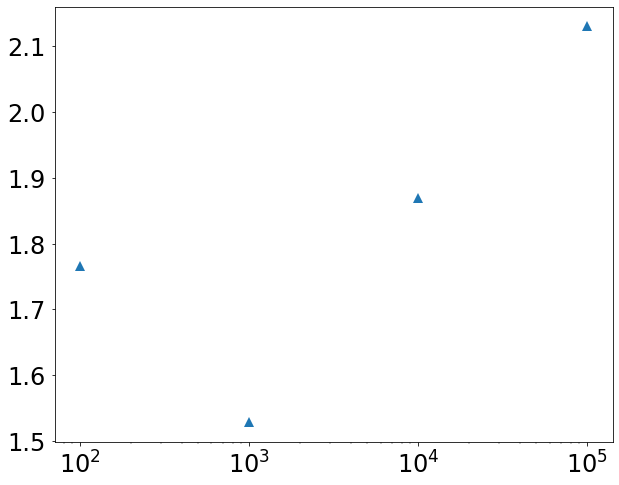

In [92]:
antigens = np.array(['IMLWCMYLILWM', 'TACNSEYPNTTK', 'QRKDGPKQKKEN'])
antigen = 'TACNSEYPNTTK'
T = .5
L = 12
Ns_dynamics = np.array([1e2, 1e3, 1e4, 1e5])
bs = np.array([])
for N_dynamics in Ns_dynamics:
    data_dynamics_tail=np.loadtxt(Text_files_path + 'Dynamics/ensemble/energies_tail_ensemble_L-%d_N-%d_Antigen-'%(L, N_dynamics)+antigen+'.txt')
    data_dynamics_tail_rho = np.histogram(data_dynamics_tail[:,0], bins = 10, density = False) # Creating histograms
    #e_max_dynamics_tail = data_dynamics_tail_rho[1][-2]
    #e_min_dynamics_tail = data_dynamics_tail_rho[1][0]

    e_dynamics_tail = data_dynamics_tail_rho[1][:-1] + abs(data_dynamics_tail_rho[1][1:]-data_dynamics_tail_rho[1][:-1])/2
    rho_e_dynamics_tail = data_dynamics_tail_rho[0]*1e10
    e_lineal = e_dynamics_tail[:3]
    rho_e_lineal = rho_e_dynamics_tail[:3]
    popt, pcov = curve_fit(my_linear_func, e_lineal, np.log(rho_e_lineal), p0 = (60,1))
    bs = np.append(bs, popt[1])
    
fig, ax = plt.subplots(figsize = (10,8))
ax.plot(Ns_dynamics, bs, marker = '^', linestyle = '', ms = 10)
ax.tick_params(labelsize = 24)
#ax.set_yscale('log')
ax.set_xscale('log')



[78.26962392  0.89093472]


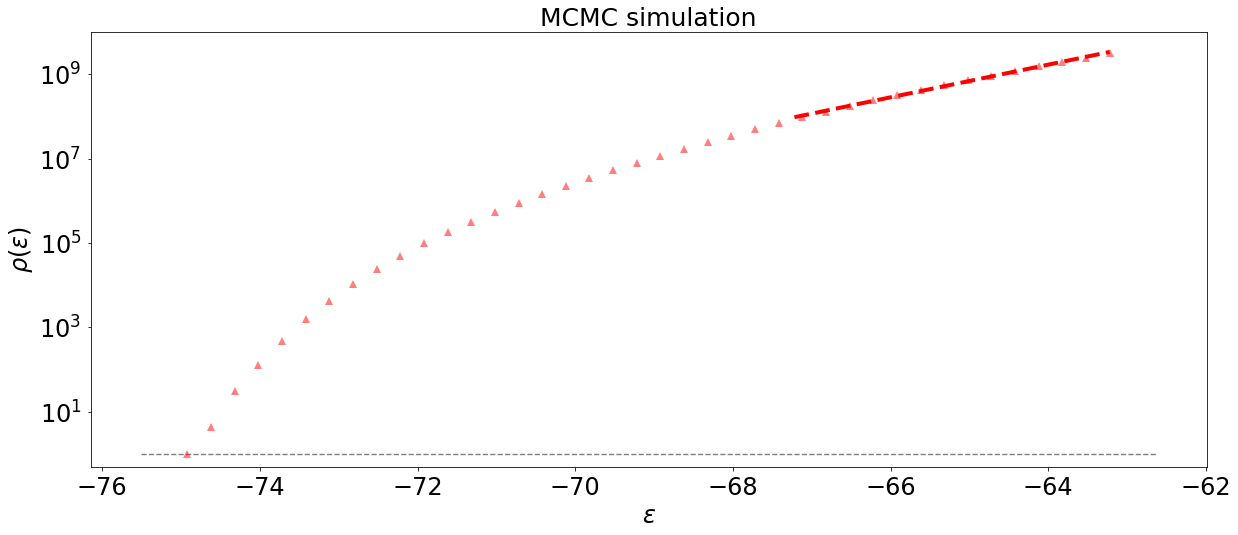

In [27]:
L = 12
N = 1e8
colors = np.flip(plt.cm.rainbow(np.linspace(0,1,3)), axis = 0)
markers = ['^', 'o', 's', '*', 'x']
E_0s = np.array([])
T = .8
naive_range = 4
master_sequences = np.array(['IMLWCMYLILWM', 'TACNSEYPNTTK', 'QRKDGPKQKKEN'])
master_sequence = 'IMLWCMYLILWM'

fig, ax = plt.subplots(figsize = (20,8))
data=(np.loadtxt(Text_files_path + 'MCMC/output_L-%d_T-%.6f_N-%d_Antigen-'%(L,T, N)+master_sequence+'.txt'))
E = data[:,0] # Column with energies from text file
data_E = np.histogram(E, bins = 40, density = False) # Creating histograms
e_max = data_E[1][-2]
e_array = np.linspace(e_max-naive_range, e_max, 100)    
rho_e = (data_E[0]/(np.exp(-data_E[1][:-1]/T)))/(data_E[0][0]/(np.exp(-data_E[1][0]/T)))
e = data_E[1][:-1]
e2 = e[np.where(e>(e_max-naive_range))]
rho_e2 = rho_e[np.where(e>(e_max-naive_range))]
popt, pcov = curve_fit(my_linear_func, e2, np.log(rho_e2), p0 = (60,1))
print(popt)
ax.plot(e, rho_e, linestyle = "", marker = markers[0], color = colors[0], ms = 8, alpha = .5)
ax.plot(e_array, np.exp(my_linear_func(e_array, *popt)), linestyle = "--", color = colors[0], linewidth = 4)
ax.set_title('MCMC simulation', fontsize = 25)
ax.set_xlabel(r'$\epsilon$', fontsize = 24)
ax.set_ylabel(r'$\rho(\epsilon)$', fontsize = 24)
ax.tick_params(labelsize = 24)
ax.set_yscale('log')
ax.set_ylim(bottom=0.5)
ax.hlines(1,ax.get_xlim()[0], ax.get_xlim()[1], linestyle = 'dashed', color = 'grey')
fig.savefig('../Figures/0_Shape_Space/rho.png')

In [10]:
L = 9
N = 1e8
colors = np.flip(plt.cm.rainbow(np.linspace(0,1,len(Ts))), axis = 0)
markers = ['^', 'o', 's', '*', 'x']
E_0s = np.array([])
T = 1
data=(np.loadtxt(Text_files_path + 'output_highT_N-%d.txt'%(N)))
E = data[:,0]
ds = np.linspace(0, L);
data_E = np.histogram(E, bins =np.linspace(-42.7, -18, 100), density = False);
#data_E = np.histogram(E, bins = 'auto', density = False);

b1 =  3.3676706655180557 b2 =  1.3379792315571726


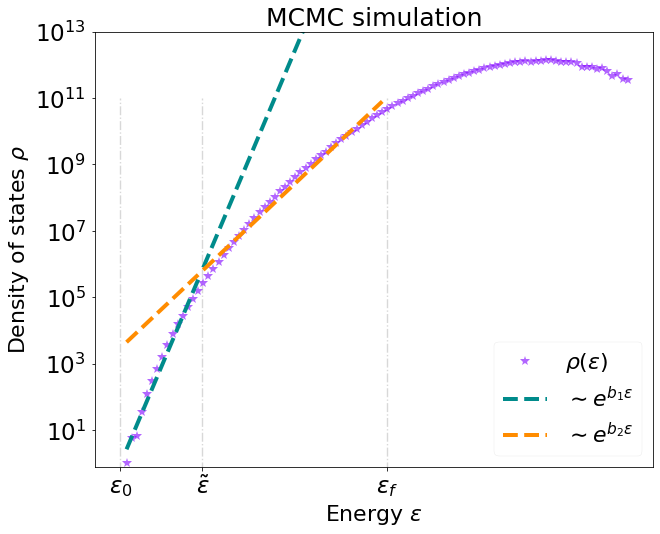

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (10,8))

deltaE = abs(-43+18)/100
E_0s = np.append(E_0s, data_E[0][0]/(np.exp(-data_E[1][0]/T)))
ax.plot(data_E[1][:-1], (data_E[0]/(np.exp(-data_E[1][:-1]/T)))/(data_E[0][0]/(np.exp(-data_E[1][0]/T))), color = colors[-1], linestyle = '', marker = '*', ms = 10, alpha = 0.6, label = r"$\rho(\epsilon)$" );

ax.set_title('MCMC simulation', fontsize = 25)
e1 = 43
e2 = 39
e3 = 30

rho_e = (data_E[0]/(np.exp(-data_E[1][:-1]/T)))/(data_E[0][0]/(np.exp(-data_E[1][0]/T)))
rho_e_1 = rho_e[np.where((data_E[1][:-1]>-e1) & (data_E[1][:-1]<-e2))]
e_1 = data_E[1][:-1][np.where((data_E[1][:-1]>-e1) & (data_E[1][:-1]<-e2))]
rho_e_2 = rho_e[np.where((data_E[1][:-1]>-e2) & (data_E[1][:-1]<-e3))]
e_2 = data_E[1][:-1][np.where((data_E[1][:-1]>-e2) & (data_E[1][:-1]<-e3))]

#ax.plot(e_1, rho_e_1, color = colors[-2], linestyle = '', marker = '*', ms = 10, alpha = 1);
#ax.plot(e_2, rho_e_2, color = colors[-3], linestyle = '', marker = '*', ms = 10, alpha = 1);


popt1, pcov1 = curve_fit(my_linear_func, e_1, np.log(rho_e_1))
popt2, pcov2 = curve_fit(my_linear_func, e_2, np.log(rho_e_2))


#ax.plot(e, np.exp(my_quadratic_func(e,*popt)), color = colors[-2], linewidth = 3, linestyle = '--', marker = '', ms = 10, alpha = 1);
ax.plot(e_1, np.exp(my_linear_func(e_1,*popt1)), color = 'darkcyan', linewidth = 4, linestyle = '--', marker = '', ms = 10, alpha = 1, label = r'$\sim e^{b_{1}\epsilon}$');
ax.plot(e_2, np.exp(my_linear_func(e_2,*popt1)), color = 'darkcyan', linewidth = 4, linestyle = '--', marker = '', ms = 10, alpha = 1);


ax.plot(e_2, np.exp(my_linear_func(e_2,*popt2)), color = 'darkorange', linewidth = 4, linestyle = '--', marker = '', ms = 10, alpha = 1, label = r'$\sim e^{b_{2}\epsilon}$');
ax.plot(e_1, np.exp(my_linear_func(e_1,*popt2)), color = 'darkorange', linewidth = 4, linestyle = '--', marker = '', ms = 10, alpha = 1);
ax.vlines([-e1, -e2, -e3], 0, 1e11, color = 'grey', linestyle = '-.', alpha = .3)

#ax.set_xlim(-43, -25)
ax.set_ylim(0.8, 1e13)
ax.set_yscale('log');
ax.set_xlabel('Energy $\epsilon$', fontsize = 22)
ax.set_ylabel(r'Density of states $\rho$', fontsize = 22)
ax.set_xticks([-e1, -e2, -e3])
ax.set_xticklabels([r'$\epsilon_0$', r'$\tilde{\epsilon}$', r'$\epsilon_f$'])
ax.tick_params(labelsize = 23)
ax.legend(loc = 4, fontsize = 22)
#fig.savefig('../Figures/density_seqs_MCMC_exponential.png')

print('b1 = ', popt1[1], 'b2 = ', popt2[1])

## This need to be copied later in the other notebook

4.7066642366754055 6.30195997717747 9.90195997717747


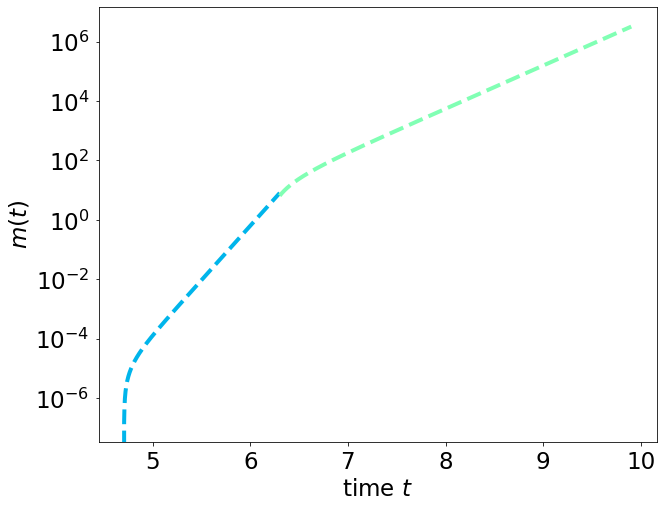

In [12]:
beta = 2.5

t1 = (-popt1[0]/popt1[1] + np.log(N_A))/beta
t2 = (-e2 + np.log(N_A))/beta
t3 = (-e3 + np.log(N_A))/beta


print(t1, t2, t3)
t_1 = np.linspace(t1,t2,1000)
t_2 = np.linspace(t2,t3,1000)

t0 = 4
b1 = popt1[1]
b2 = popt2[1]

alpha2 = np.exp(popt2[0])*np.exp(b2*(-popt1[0]/popt1[1]))

delta = 1e-4

m1 = delta*(np.exp(b1*beta*(t_1-t1))-1)/(b1*beta)
m2 = delta*(((alpha2*np.exp(b2*beta*(t_2-t1)))/(beta*b2)) + ((np.exp(beta*b1*(t2-t1))*(1/b1 - 1/b2))/(beta)) - ((1)/(beta*b1)))

fig, ax = plt.subplots(1, 1, figsize = (10,8))
ax.plot(t_1, m1, color = colors[-2], linewidth = 4, linestyle = '--')
ax.plot(t_2, m2, color = colors[-3], linewidth = 4, linestyle = '--')
ax.tick_params(labelsize = 23)
ax.set_xlabel(r'time $t$', fontsize = 23)
ax.set_ylabel(r'$m(t)$', fontsize = 23)
ax.set_yscale('log')

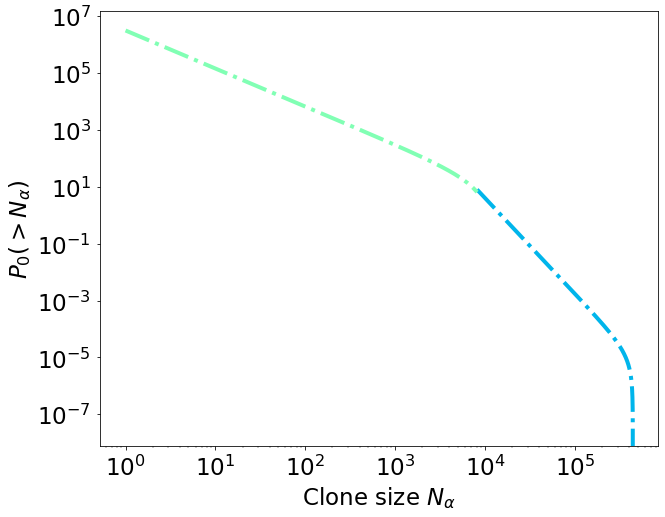

In [13]:
beta = 2.5
nu = 2.5

N_alpha1 = np.linspace(np.exp(nu*(t3-t2)), np.exp(nu*(t3-t1)), 1000)
N_alpha2 = np.linspace(np.exp(nu*(t3-t3)), np.exp(nu*(t3-t2)), 1000)

m1 = delta*(np.exp(b1*beta*(t3-t1))*N_alpha1**(-(beta*b1)/(nu))-1)/(b1*beta)
m2 = delta*(((alpha2*np.exp(b2*beta*(t3-t1))*N_alpha2**(-(beta*b2)/(nu)))/(beta*b2)) + ((np.exp(beta*b1*(t2-t1))*(1/b1 - 1/b2))/(beta)) - ((1)/(beta*b1)))

fig, ax = plt.subplots(1, 1, figsize = (10,8))
ax.plot(N_alpha1, m1, color = colors[-2], linewidth = 4, linestyle = '-.')
ax.plot(N_alpha2, m2, color = colors[-3], linewidth = 4, linestyle = '-.')
ax.tick_params(labelsize = 23)
ax.set_xlabel(r'Clone size $N_\alpha$', fontsize = 23)
ax.set_ylabel(r'$P_0(>N_\alpha)$', fontsize = 23)
ax.set_xscale('log')
ax.set_yscale('log')


## Different energetic regions for the MS

In [14]:
data_MS = np.histogram(master_sequences_energies, density = True, bins = 50)

[78.26962392  0.89093472]
[54.95566539  0.8964469 ]
[49.92588904  0.90586496]


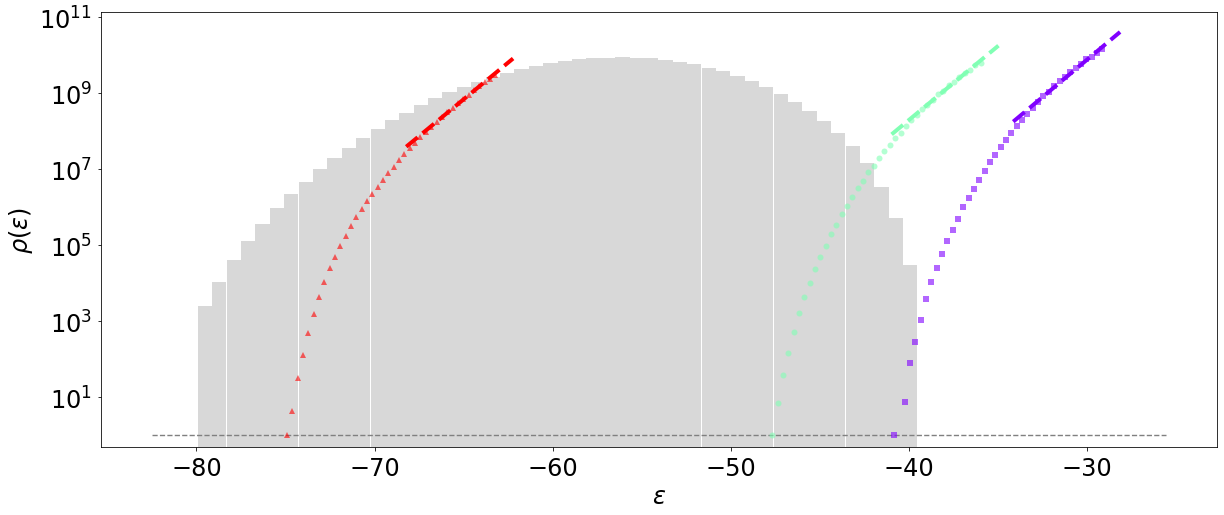

In [17]:
L = 12
N = 1e8
colors = np.flip(plt.cm.rainbow(np.linspace(0,1,3)), axis = 0)
markers = ['^', 'o', 's', '*', 'x']
E_0s = np.array([])
T = .8
naive_range = 4
antigens = ['IMLWCMYLILWM', 'TACNSEYPNTTK', 'QRKDGPKQKKEN']

fig, ax = plt.subplots(figsize = (20,8))
for i, antigen in enumerate(antigens):
    data=(np.loadtxt(Text_files_path + 'output_L-%d_T-%.6f_N-%d_Antigen-'%(L,T, N)+antigen+'.txt'))
    E = data[:,0] # Column with energies from text file
    data_E = np.histogram(E, bins = 40, density = False) # Creating histograms
    e_max = data_E[1][-2]
    e_array = np.linspace(e_max-naive_range-1, e_max+1, 100)    
    rho_e = (data_E[0]/(np.exp(-data_E[1][:-1]/T)))/(data_E[0][0]/(np.exp(-data_E[1][0]/T)))
    e = data_E[1][:-1]
    e2 = e[np.where(e>(e_max-naive_range))]
    rho_e2 = rho_e[np.where(e>(e_max-naive_range))]
    popt, pcov = curve_fit(my_linear_func, e2, np.log(rho_e2), p0 = (60,1))
    print(popt)
    ax.plot(e, rho_e, linestyle = "", marker = markers[i], color = colors[i], ms = 6, alpha = .6)
    ax.plot(e_array, np.exp(my_linear_func(e_array, *popt)), linestyle = "--", color = colors[i], linewidth = 4)
    
ax.set_xlabel(r'$\epsilon$', fontsize = 24)
ax.set_ylabel(r'$\rho(\epsilon)$', fontsize = 24)
ax.tick_params(labelsize = 24)
ax.set_yscale('log')
ax.bar(data_MS[1][:-1], data_MS[0]*1e11, color = 'grey', alpha = 0.3)
ax.set_ylim(bottom=0.5)
ax.hlines(1,ax.get_xlim()[0], ax.get_xlim()[1], linestyle = 'dashed', color = 'grey')
fig.savefig('../Figures/0_Shape_Space/range_MS.png')

# other plots

## Sequences generated from the MS

In [ ]:
%%time
L = 9
n_seqs = np.array([1e2, 1e3, 1e4, 1e5, 1e6])
Array_Sequences = []

for n_seq in n_seqs:
    Sequences = pickle.load( open( Text_files_path + "Sequences_MJ2_L-%d_n_seq-%d.pkl"%(L, n_seq), "rb" ) )
    Array_Sequences.append(Sequences)
    print('Master Seq:', Sequences[0].sequence, 'Antigen Seq:', Sequences[0].complementary_sequence)
    
Array_Sequences = np.array(Array_Sequences, dtype = Sequence)

In [ ]:
for k, Sequences in enumerate(Array_Sequences):
    fig1, ax1 = plt.subplots(1,1,figsize=(10,8))
    distances = plot_histogram_hamming_distance(Sequences = Sequences, ax = ax1)
    plt.close()
    
fig, ax = plt.subplots(1,1,figsize=(10,8))
colors = plt.cm.Reds(np.linspace(0,1,len(n_seqs)))
for k, Sequences in enumerate(Array_Sequences):
    energies, data_energies = plot_histogram_energy(Sequences = Sequences, normalization = 1, bins = 'auto', color = colors[k], n_seq = n_seqs[k], density = True, ax = ax)
#ax.set_xlim(np.min(energies),np.min(energies)+8 )
#ax.set_yscale('linear')

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (10, 8))
ds = np.array(range(1,10))
for k, Sequences in enumerate(Array_Sequences):
    #calculate mean energy given d
    mean_energies_given_d = np.array([])

    for d in ds:
        temp_array = [Sequences[i].energy for i in range(int(len(Sequences))) if (Sequences[i].hamming_distance == d)]
        mean_energy_given_d = np.mean(temp_array)
        var_energy_given_d = np.var(temp_array)
        mean_energies_given_d = np.append(mean_energies_given_d, mean_energy_given_d)
        
    #___________________________________________
    #plot_scatter_hamming_distance_energy(distances = distances, energies = energies, color = 'steelblue', ax = ax)
    #plot_scatter_hamming_distance_energy(distances = distances_left_tail_8, energies = energies_left_tail_8, color = 'olivedrab', ax = ax)
    ax.scatter(range(1,10), mean_energies_given_d, color = colors[k], s = 120, marker = '*', label = 'N=%.e'%(n_seqs[k]))
    ax.vlines(range(1,10), mean_energies_given_d-np.sqrt(var_energy_given_d), mean_energies_given_d+np.sqrt(var_energy_given_d), color = colors[k], linestyle = '--')
    ax.hlines(np.min(energies)+8, 0, 9, color = 'olive', linestyle = '--')
    ax.legend(loc = 0, fontsize = 22)
    
#-------------------------------------------------
# Fit the mean value to a linear function
popt, pcov = curve_fit(my_linear_func, ds, mean_energies_given_d)

ax.plot(ds, my_linear_func(ds, *popt), linewidth = 2, linestyle = '--', color = 'black')



## Sequences generated randomly

In [ ]:
%%time
L = 9
n_seqs = np.array([1e2, 1e3, 1e4, 1e5, 1e6])
Array_Sequences_random = []

for n_seq in n_seqs:
    Sequences = pickle.load( open( Text_files_path + "Sequences_random_MJ2_L-%d_n_seq-%d.pkl"%(L, n_seq), "rb" ) )
    for Sequence_i in Sequences:
        Sequence_i.hamming_distance = hamming_distance(Sequence_i.sequence, Sequence_i.complementary_sequence)
    Array_Sequences_random.append(Sequences)
    print('Master Seq:', Sequences[0].sequence, 'Antigen Seq:', Sequences[0].complementary_sequence)

Array_Sequences_random = np.array(Array_Sequences_random, dtype = Sequence)




In [ ]:
for k, Sequences in enumerate(Array_Sequences_random):
    fig1, ax1 = plt.subplots(1,1,figsize=(10,8))
    distances = plot_histogram_hamming_distance(Sequences = Sequences, ax = ax1)
    plt.close()

fig, ax = plt.subplots(1,1,figsize=(10,8))
colors = plt.cm.Reds(np.linspace(0,1,len(n_seqs)))
min_seqs = np.array([])
for k, Sequences in enumerate(Array_Sequences_random):
    energies, data_energies = plot_histogram_energy(Sequences = Sequences, normalization = 1, bins = 'auto', color = colors[k], n_seq = n_seqs[k], density = True, ax = ax)
    min_energy = np.min(energies)
    min_seqs = np.append(min_seqs, [i.sequence for i in Sequences if (i.energy == min_energy)])
    
min_seqs
#ax.set_yscale('linear')

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (10, 8))

for k, Sequences in enumerate(Array_Sequences_random):
    #calculate mean energy given d
    mean_energies_given_d = np.array([])

    for d in range(1,10):
        temp_array = [Sequences[i].energy for i in range(int(len(Sequences))) if (Sequences[i].hamming_distance == d)]
        mean_energy_given_d = np.mean(temp_array)
        var_energy_given_d = np.var(temp_array)
        mean_energies_given_d = np.append(mean_energies_given_d, mean_energy_given_d)
    #-------------------------------------------------- 
    #___________________________________________
    #plot_scatter_hamming_distance_energy(distances = distances, energies = energies, color = 'steelblue', ax = ax)
    #plot_scatter_hamming_distance_energy(distances = distances_left_tail_8, energies = energies_left_tail_8, color = 'olivedrab', ax = ax)
    ax.scatter(range(1,10), mean_energies_given_d, color = colors[k], s = 120, marker = '*', label = 'N=%.e'%(n_seqs[k]))
    ax.vlines(range(1,10), mean_energies_given_d-np.sqrt(var_energy_given_d), mean_energies_given_d+np.sqrt(var_energy_given_d), color = colors[k], linestyle = '--')
    ax.hlines(np.min(energies)+8, 0, 9, color = 'olive', linestyle = '--')
    ax.legend(loc = 0, fontsize = 22)

ax.plot(ds, my_linear_func(ds, *popt), linewidth = 2, linestyle = '--', color = 'black')

In [2]:
np.log(1E8)

18.420680743952367

## Range of energies ; $\epsilon_{best} - \epsilon_{worst}$

In [ ]:
%%time
L = 9
n_seqs = np.array([5e5])
fig, ax = plt.subplots(figsize=(10,8))

for n_seq in n_seqs:
    range_energies = pickle.load(open(Text_files_path+'range_energies_MJ2_L-%d_n_seq-%d.pkl'%(int(L), int(n_seq)), 'rb'))
    ax.hist(range_energies, density = True, bins = 'auto', label = 'n_seq=%.e'%(n_seq));
ax.legend(loc = 0, fontsize = 22)

## Master sequence energy distribution

In [ ]:
%%time
L = 12
n_seqs = np.array([1e8])
fig, ax = plt.subplots(figsize=(10,8))

for n_seq in n_seqs:
    master_sequences_energies = np.loadtxt(Text_files_path+'MS_energies_L-%d_N-%d.txt'%(int(L), int(n_seq)))
    ax.hist(master_sequences_energies, density = True, bins = 'auto', label = 'n_seq=%.e'%(n_seq));
ax.legend(loc = 0, fontsize = 22)
ax.set_yscale('log')